In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

# VGG Model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import gram_matrix, recover_image, tensor_normalizer
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  kwargs = {'num_workers': 4, 'pin_memory': True}
else:
  kwargs = {}

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "coco_2017/validation"

transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])

train_dataset = datasets.ImageFolder(DATASET, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
  loss_network = LossNetwork()
  loss_network.to(device)
loss_network.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [6]:
loss_network

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [7]:
STYLE_IMAGE = "style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
  style_img_tensor = transforms.Compose([
                                         transforms.ToTensor(),
                                         tensor_normalizer()])(style_img).unsqueeze(0)
  style_img_tensor = style_img_tensor.to(device)

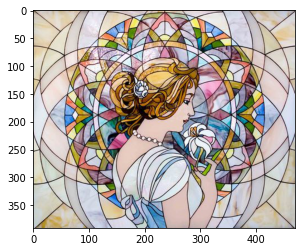

In [8]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])
plt.show()

In [9]:
with torch.no_grad():
  style_loss_features = loss_network(style_img_tensor)
  gram_style = [gram_matrix(y) for y in style_loss_features]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
  style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [11]:
for i in range(len(style_loss_features)):
  tmp = style_loss_features[i].cpu().numpy()
  print(i, np.mean(tmp), np.std(tmp))

0 0.8696425 2.0772192
1 1.3954027 3.5784333
2 1.7436607 6.0051637
3 0.40489754 1.6580398
4 0.08247852 0.4453365


In [12]:
for i in range(len(style_loss_features)):
  print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])
4 262144 torch.Size([1, 512, 512])


# Train the Transformer / Image Generator¶


In [13]:
def save_debug_image(tensor_orig, tensor_transformed, tensor_with_noise, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 3 + 10, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.paste(noise, (result.size[0] * 2 + 10,0))
    new_im.save(filename)

In [14]:
%mkdir -p ../debug

In [15]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [24]:
torch.set_default_tensor_type('torch.FloatTensor')
   
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    agg_stable_loss = 0.
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
            with torch.no_grad():                      
                mask = torch.bernoulli(torch.ones_like(
                    x, device=device, dtype=torch.float
                ) * NOISE_P)
                noise = torch.normal(
                    torch.zeros_like(x), 
                    torch.ones_like(
                        x, device=device, dtype=torch.float
                    ) * NOISE_STD
                ).clamp(-1, 1)
                # print((noise * mask).sum())
            y_noise = transformer(x + noise * mask)
                        
            with torch.no_grad():
                xc = x.detach()
                features_xc = loss_network(xc)
            
            features_y = loss_network(y)
            
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

            total_loss = content_loss + style_loss + reg_loss + stability_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            agg_stable_loss += stability_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} stable: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            agg_stable_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss + agg_stable_loss) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), y_noise.detach(), "../debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [25]:
len(train_loader)

1250

In [26]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3
REGULARIZATION = 1e-6
NOISE_P = 0.2
NOISE_STD = 0.35
NOISE_WEIGHT = 10 * 2
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

In [27]:
train(1000, 0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sun Aug 29 15:23:18 2021 [50/1000] content: 20.27  style: 27.65  reg: 0.12 stable: 0.08 total: 48.123764
Sun Aug 29 15:23:36 2021 [100/1000] content: 23.38  style: 15.43  reg: 0.20 stable: 0.18 total: 39.193279
Sun Aug 29 15:23:54 2021 [150/1000] content: 22.46  style: 12.89  reg: 0.23 stable: 0.25 total: 35.829151
Sun Aug 29 15:24:12 2021 [200/1000] content: 22.20  style: 12.15  reg: 0.25 stable: 0.27 total: 34.872383
Sun Aug 29 15:24:30 2021 [250/1000] content: 21.39  style: 11.85  reg: 0.26 stable: 0.32 total: 33.819309
Sun Aug 29 15:24:48 2021 [300/1000] content: 20.33  style: 11.23  reg: 0.27 stable: 0.32 total: 32.152508
Sun Aug 29 15:25:06 2021 [350/1000] content: 19.91  style: 11.32  reg: 0.27 stable: 0.39 total: 31.889174
Sun Aug 29 15:25:25 2021 [400/1000] content: 19.24  style: 10.97  reg: 0.27 stable: 0.35 total: 30.825493
Sun Aug 29 15:25:43 2021 [450/1000] content: 18.67  style: 10.58  reg: 0.27 stable: 0.39 total: 29.911774
Sun Aug 29 15:26:02 2021 [500/1000] content: 18

In [28]:
optimizer = Adam(transformer.parameters(), LR * 0.5)

In [29]:
train(3000, 1000)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sun Aug 29 15:30:39 2021 [50/3000] content: 16.02  style: 9.98  reg: 0.27 stable: 0.46 total: 26.729448
Sun Aug 29 15:30:58 2021 [100/3000] content: 15.71  style: 9.98  reg: 0.27 stable: 0.46 total: 26.413414
Sun Aug 29 15:31:16 2021 [150/3000] content: 15.68  style: 10.18  reg: 0.27 stable: 0.49 total: 26.619299
Sun Aug 29 15:31:35 2021 [200/3000] content: 15.79  style: 9.92  reg: 0.27 stable: 0.51 total: 26.493992
Sun Aug 29 15:31:53 2021 [250/3000] content: 15.46  style: 9.85  reg: 0.27 stable: 0.44 total: 26.026546
Sun Aug 29 15:32:12 2021 [300/3000] content: 15.50  style: 9.71  reg: 0.28 stable: 0.48 total: 25.967381
Sun Aug 29 15:32:30 2021 [350/3000] content: 15.39  style: 9.86  reg: 0.28 stable: 0.45 total: 25.971577
Sun Aug 29 15:32:49 2021 [400/3000] content: 15.43  style: 9.80  reg: 0.28 stable: 0.51 total: 26.017834
Sun Aug 29 15:33:07 2021 [450/3000] content: 15.52  style: 10.03  reg: 0.28 stable: 0.50 total: 26.326010
Sun Aug 29 15:33:26 2021 [500/3000] content: 15.17  st

In [35]:
save_model_path = "models/mosaic_4000_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [36]:
optimizer = Adam(transformer.parameters(), LR * 0.1)

In [37]:
LOG_INTERVAL = 100
train(6000, 4000)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sun Aug 29 15:58:41 2021 [100/6000] content: 13.42  style: 9.22  reg: 0.28 stable: 0.54 total: 23.458204
Sun Aug 29 15:59:17 2021 [200/6000] content: 13.27  style: 9.03  reg: 0.28 stable: 0.57 total: 23.143564
Sun Aug 29 15:59:53 2021 [300/6000] content: 13.45  style: 9.26  reg: 0.28 stable: 0.60 total: 23.588383
Sun Aug 29 16:00:30 2021 [400/6000] content: 13.33  style: 9.14  reg: 0.27 stable: 0.61 total: 23.353691
Sun Aug 29 16:01:07 2021 [500/6000] content: 13.30  style: 9.19  reg: 0.27 stable: 0.61 total: 23.375629
Sun Aug 29 16:01:44 2021 [600/6000] content: 13.28  style: 9.06  reg: 0.28 stable: 0.52 total: 23.138193
Sun Aug 29 16:02:21 2021 [700/6000] content: 13.12  style: 9.07  reg: 0.28 stable: 0.57 total: 23.043230
Sun Aug 29 16:02:58 2021 [800/6000] content: 13.13  style: 9.02  reg: 0.28 stable: 0.53 total: 22.954540
Sun Aug 29 16:03:35 2021 [900/6000] content: 13.20  style: 9.15  reg: 0.28 stable: 0.57 total: 23.192785
Sun Aug 29 16:04:12 2021 [1000/6000] content: 13.05  st

In [38]:
save_model_path = "models/mosaic_10000_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [40]:
transformer = transformer.eval()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


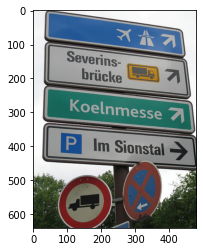

In [45]:
img = Image.open(fnames[50]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

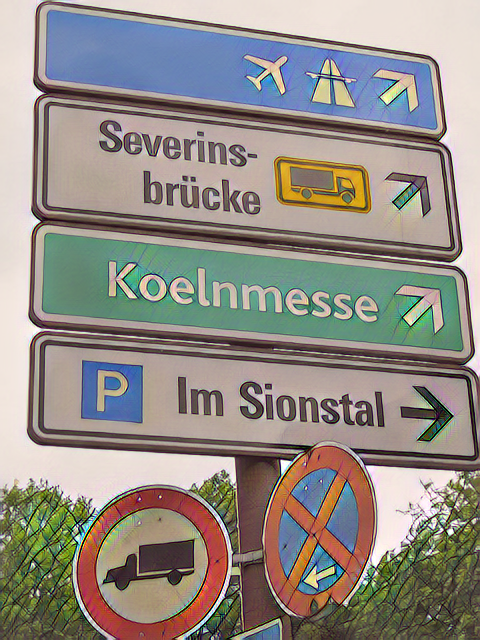

In [46]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


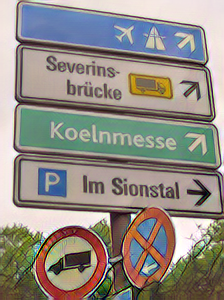

In [47]:
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 512, 512])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


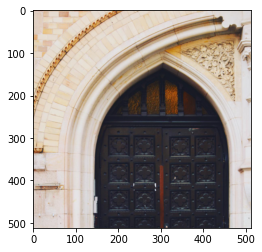

In [51]:
img = Image.open("content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

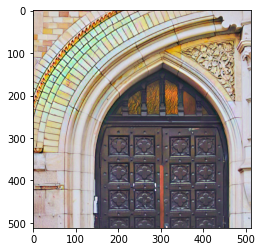

In [52]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])